# Scientific Programming and Dynamical Modelling in Julia
#### Winter Semester 23/24, TUM
---
## Exercise 4: Lypapunov Exponents

In [1]:
using Pkg
Pkg.activate("env_ex4.jl")
using DynamicalSystems
using OrdinaryDiffEq    # Component package of DifferentialEquations.jl for solving ODEs
using CairoMakie        # Alternative to Plots.jl
using Plots, Plots.PlotMeasures
using Printf            # C style string formatting
using StaticArrays
using LinearAlgebra
using Statistics
using Random

  Activating project at `c:\Users\colin\OneDrive-TUM\Code\Julia\MMDS_Julia\env_ex4.jl`

### Investigating diverging behavior of similar initial conditions
#### A) Warm-Up: create a trajectory into the attractor from random initial conditions

u0:  [0.7789927538331773, 0.3772302889410417, 0.8996518610104179]


end: [-9.685628739421427, -2.5067113953278484, 35.512925353283705]


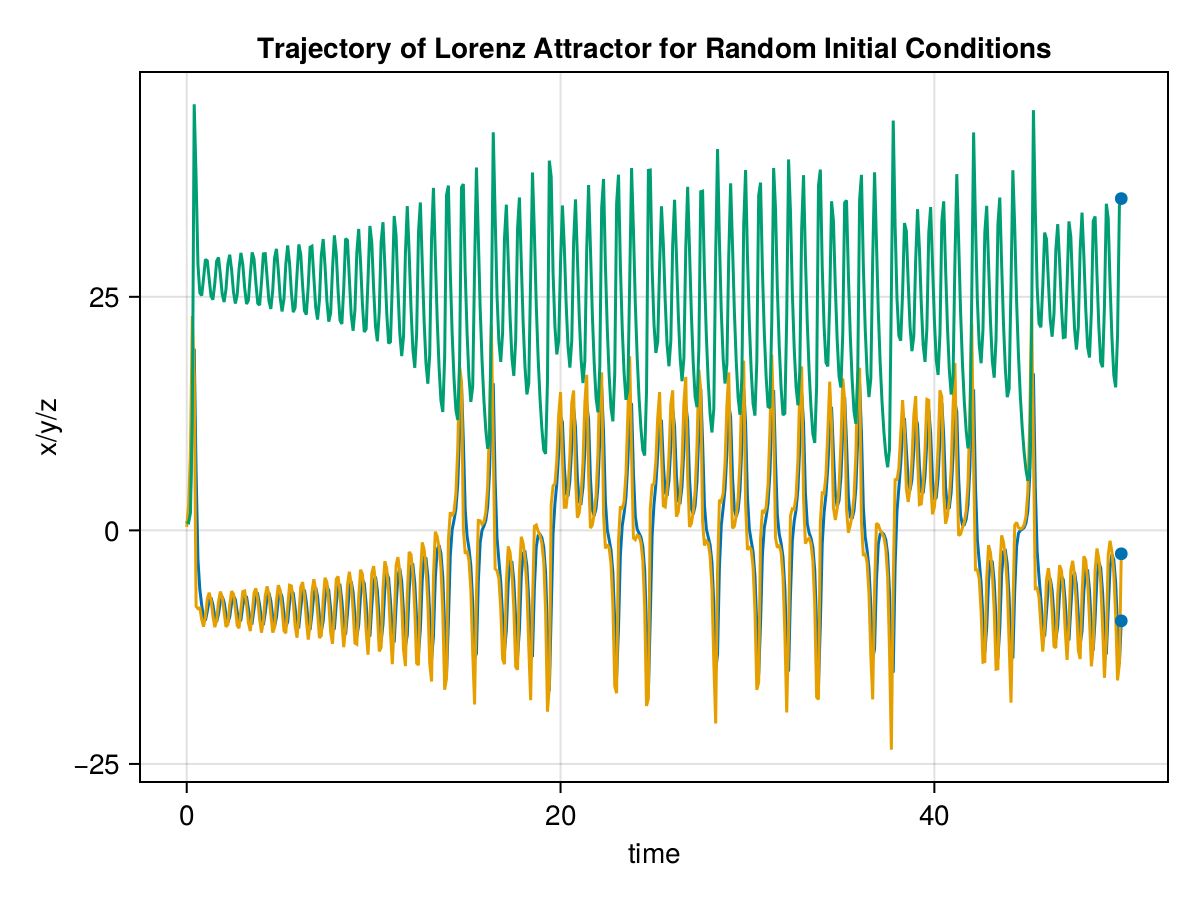

In [14]:
ds_lorenz = Systems.lorenz()
N_lorenz = 50
u0 = @SVector rand(3)
println("u0:  ", u0)
Y, t = trajectory(ds_lorenz, N_lorenz, u0)

fig = Figure()
ax = Axis(fig[1, 1]; title="Trajectory of Lorenz Attractor for Random Initial Conditions", xlabel = "time", ylabel = "x/y/z")
for var in columns(Y)
    lines!(ax, t, var)
end
end_point = Y[end]
println("end: ", end_point)
CairoMakie.scatter!(repeat([N_lorenz], 3), [end_point...])
fig

#### B) Initial Conditions: create two similar sets of initial conditions from the end-point of the warm-up trajecory

In [12]:
u_delta = SVector{3}((rand(1e-4:1e-4:1e-3, 3)))    # perturbation between 1e-4 and 1e-3

u0_1 = end_point
u0_2 = end_point + u_delta

N_lorenz2 = 20
Y1, t1 = trajectory(ds_lorenz, N_lorenz2, u0_1)
Y2, t2 = trajectory(ds_lorenz, N_lorenz2, u0_2)

Y1_matrix = Matrix(Y1)'
Y2_matrix = Matrix(Y2)';

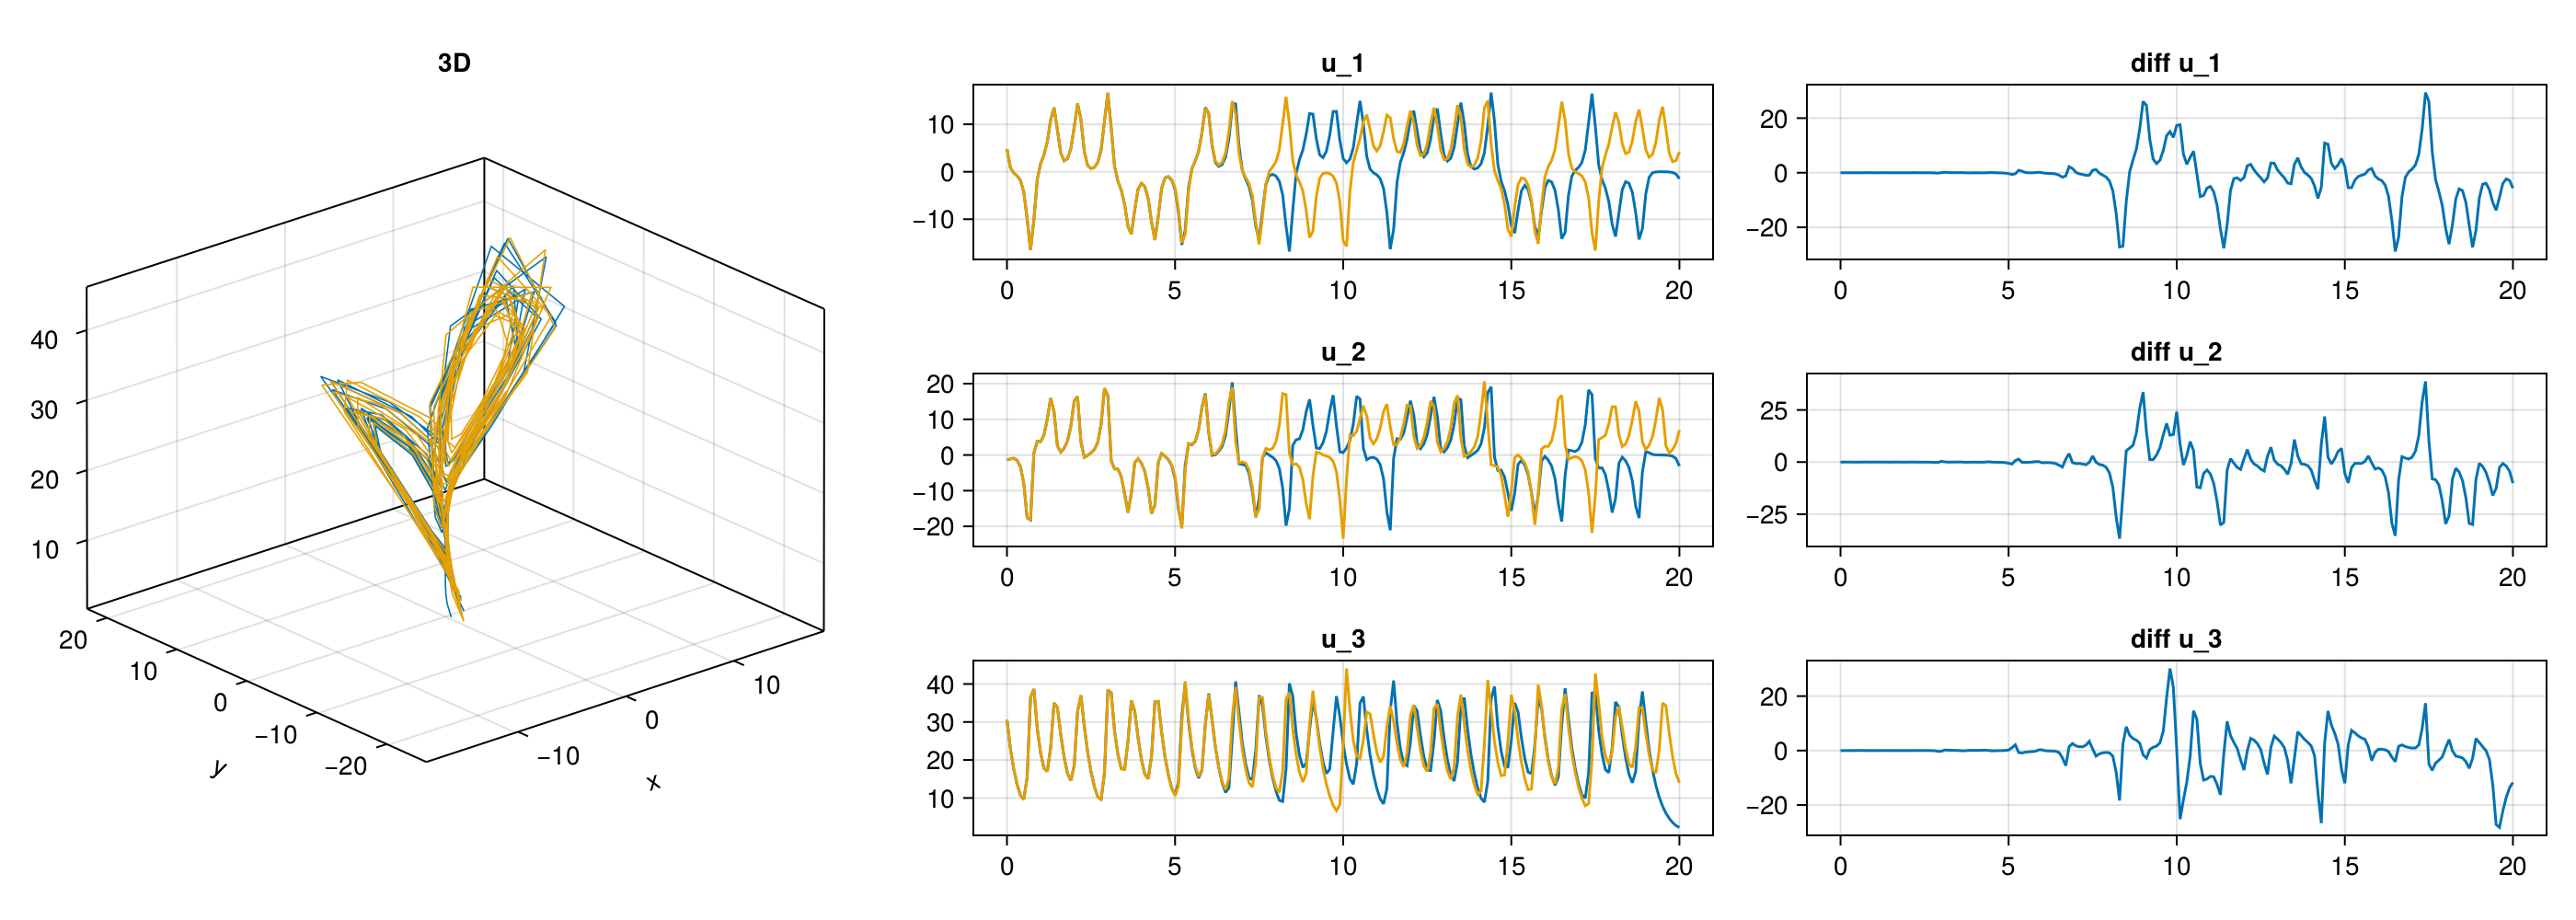

In [4]:
f = Figure(size = (1400, 500))

subgl_left = GridLayout()
subgl_left[1, 1] = [Axis3(f, title="3D")]

subgl_mid = GridLayout()
subgl_mid[1:3, 1] = [Axis(f, title="u_$i") for i in 1:3]

subgl_right = GridLayout()
subgl_right[1:3, 1] = [Axis(f, title="diff u_$i") for i in 1:3]

f.layout[1, 1] = subgl_left
f.layout[1, 2] = subgl_mid
f.layout[1, 3] = subgl_right

lines!(subgl_left[1,1], Y1[:,1], Y1[:,2], Y1[:,3], linewidth=.8)
lines!(subgl_left[1,1], Y2[:,1], Y2[:,2], Y2[:,3], linewidth=.8)

for i in range(1, 3)
    lines!(subgl_mid[i, 1], t1, Y1[:,i])
    lines!(subgl_mid[i, 1], t2, Y2[:,i])

    lines!(subgl_right[i, 1], t1, Y1[:,i]-Y2[:,i])
end

f

┌ Info: Saved animation to C:\Users\colin\AppData\Local\Temp\jl_kvsHEVAbQ5.gif
└ @ Plots C:\Users\colin\.julia\packages\Plots\sxUvK\src\animation.jl:156


Plots.AnimatedGif("C:\\Users\\colin\\AppData\\Local\\Temp\\jl_kvsHEVAbQ5.gif")
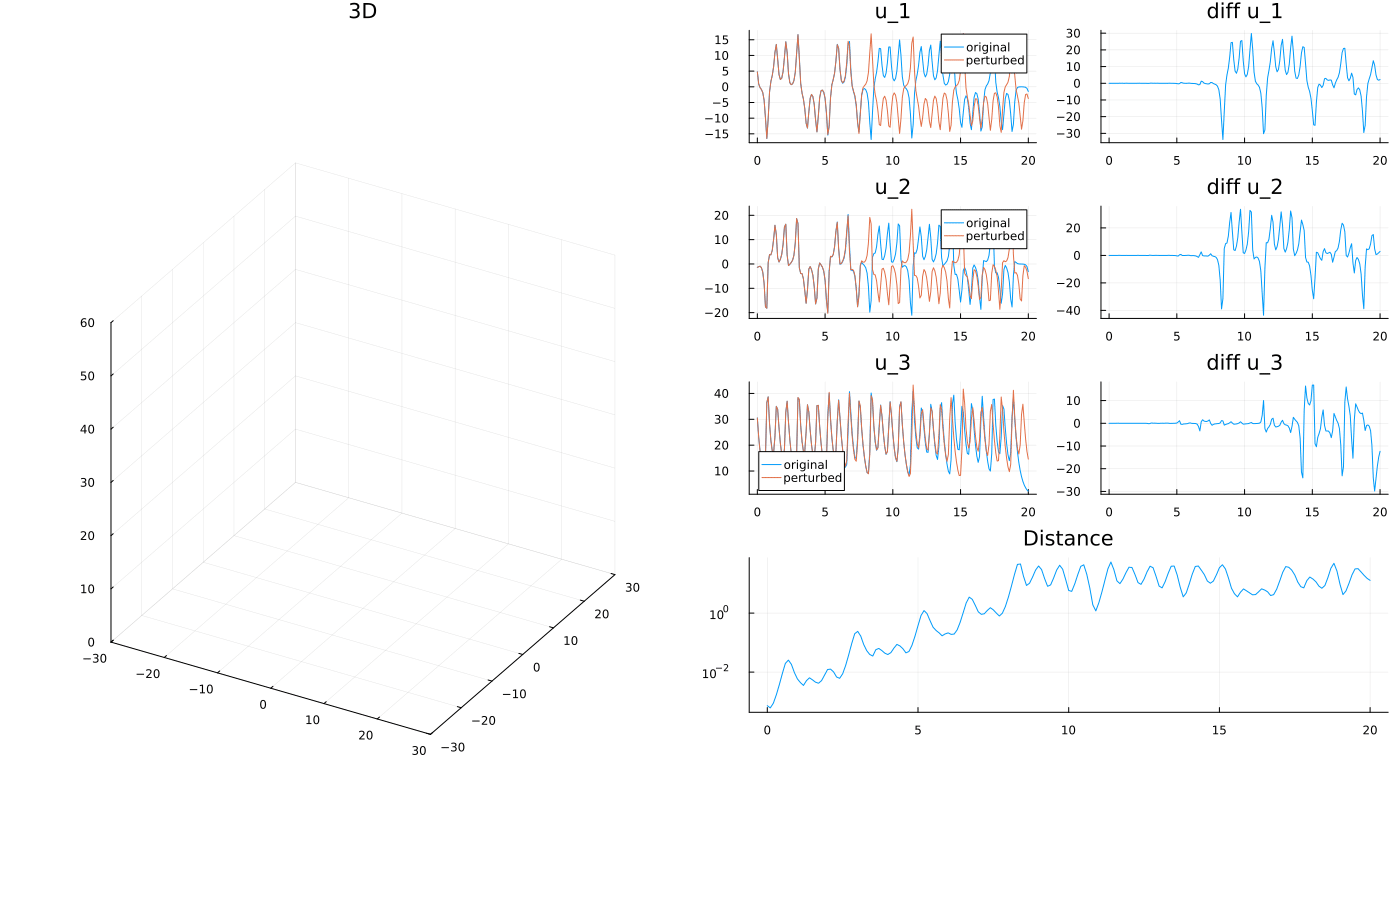

In [46]:
layout = @layout [
    a [
        grid(3,2){0.6h}
        b{0.2h}
        ]
]
plt = Plots.plot(1, size=(1400, 900), layout=layout)
Plots.plot!(subplot=1, title="3D", xlim = (-30, 30), ylim = (-30, 30), zlim = (0, 60))
Plots.plot!(t1, Y1[:,1], subplot=2, label="original", title="u_1")
Plots.plot!(t1, Y1[:,2], subplot=4, label="original", title="u_2")
Plots.plot!(t1, Y1[:,3], subplot=6, label="original", title="u_3")
Plots.plot!(t1, Y2[:,1], subplot=2, label="perturbed")
Plots.plot!(t1, Y2[:,2], subplot=4, label="perturbed")
Plots.plot!(t1, Y2[:,3], subplot=6, label="perturbed")
Plots.plot!(t1, Y1[:,1]-Y2[:,1], subplot=3, title="diff u_1", label="")
Plots.plot!(t1, Y1[:,2]-Y2[:,2], subplot=5, title="diff u_2", label="")
Plots.plot!(t1, Y1[:,3]-Y2[:,3], subplot=7, title="diff u_3", label="")

Plots.plot!(t1, [norm(y1_ - y2_) for (y1_, y2_) in zip(eachcol(Y1_matrix), eachcol(Y2_matrix))], subplot=8, title="Distance", yaxis=:log, legend=false)

@gif for i in range(1, size(Y1, 1))
# @gif for i in range(1, 5)
    plot3d!(Y1_matrix[1,1:i], Y1_matrix[2,1:i], Y1_matrix[3,1:i], color="#0077ff", linewidth=0.5, legend=false, subplot=1)
    plot3d!(Y2_matrix[1,1:i], Y2_matrix[2,1:i], Y2_matrix[3,1:i], color="#ffac7e", linewidth=0.5, legend=false, subplot=1)
end every 2

#### Observations
- the 3D plot shows how for a few steps, the trajectories remain undistinguishbly close, only to diverge completely afterwards
- the first column of 2D plots shows the same behavior in more detail, where $u_1$ and $u_2$ show similar behavior, where after ~8s the two trajectories stasrt to diverge
- $u_3$ starts to diverge later than the two other dimensions
- the second column of 2D plots depicts the difference between the two trajectories, again the similar behavior in the first two dimensions can be observed
- the final bottom plot shows the absolute distance of the trajectories growing over time, until saturating eventually due to the trajectories being bounded by the attractor

### Estimation of the Lyapunov Exponent
The largest Lyapunov Exponent characterizes the dominant behavior of a dynamical system, as the difference between two trajectories is approximated by

$ \phantom{space}\delta(t) \approx \delta _0 \cdot e^{\lambda_{max}\;t}$ 

such that

- $\lambda_{max}$ > 0: growing difference
- $\lambda_{max}$ < 0: decaying difference
- $\lambda_{max}$ imaginary: oscillatory

In the following, a naive routine for estimating the largest Lyapunov exponent is implemented and discussed.

In [8]:
function estimate_lyapunov_exponent(ds, u0, T_traj; n_exp=2, delta=[1e-4, 1e-3], dt=0.1)
    """
    Estimates the maximum Lyapunov exponent of a dynamical system by averaging multiple experiments.
    Determines the exponent by fitting a linear regression in log space.

    Returns the time vector `t`, the differences in trajectories of the multiple experiments `diff_accum`,
    the mean initial deviation `line_coeffs` and the averaged estimate of the exponent `lyapunov` as estimated by the regression.
    """
    n_dim = size(u0, 1)
    t = 0:dt:T_traj
    n_traj = size(t, 1)
    diff_accum = zeros(n_traj, n_exp)
    line_coeffs = fill(-1., (2, n_exp))
    for i in range(1, n_exp)
        u_delta = SVector{n_dim}((rand(delta[1]:delta[1]:delta[2], n_dim)))
        u0_1 = u0
        u0_2 = u0 + u_delta

        Y1, t1 = trajectory(ds, T_traj, u0_1, Δt=dt)
        Y2, t2 = trajectory(ds, T_traj, u0_2, Δt=dt)
        diff = [norm(y1_ - y2_) for (y1_, y2_) in zip(eachrow(Y1), eachrow(Y2))]
        diff_log = log.(diff)
        
        # linear fit to log differences
        A = [ones(n_traj) t]
        b, a = A\diff_log
        
        # aggregate data
        line_coeffs[:, i] = A\diff_log
        diff_accum[:, i] = diff
    end
    log_delta0_mean, lyapunov = mean(line_coeffs; dims=2)
    delta0_mean = exp(log_delta0_mean)
    return t, diff_accum, line_coeffs, delta0_mean, lyapunov
end

estimate_lyapunov_exponent (generic function with 1 method)

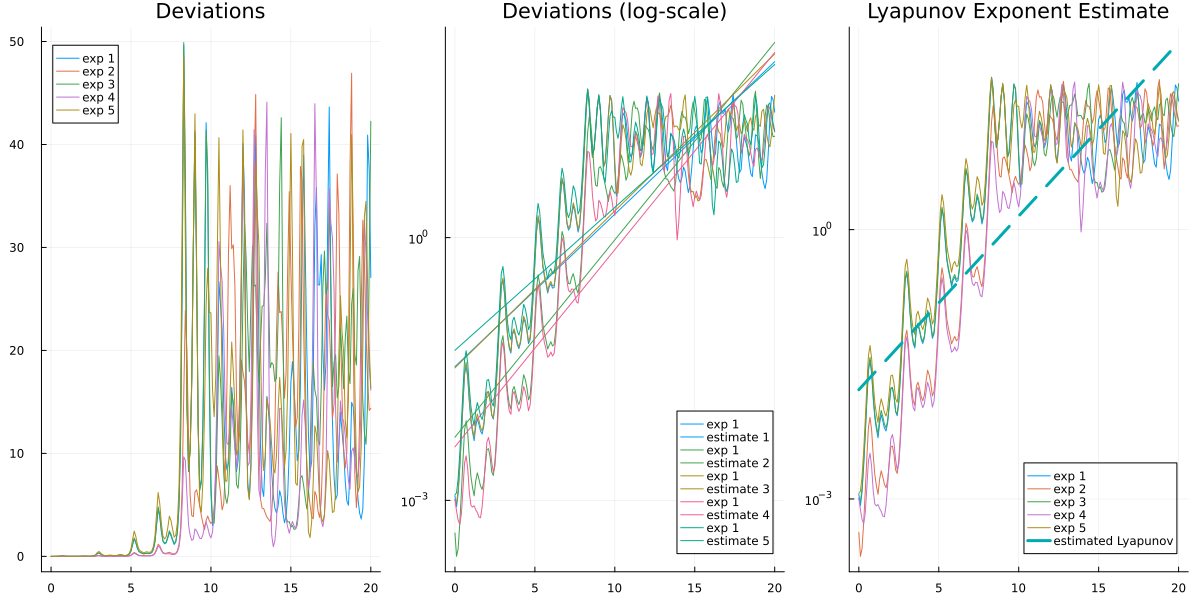

In [9]:
# define experiment parameters
n_exps = 5
T_traj = 20

# run experiment
t, diffs, coeffs, delta0_mean, lyapunov = estimate_lyapunov_exponent(Systems.lorenz(), end_point, T_traj; n_exp=n_exps, delta=[1e-4, 1e-3], dt=0.1)

# create the estimate deviation according to δ(t) = δ_0 * exp(λ*t)
delta_estimate = delta0_mean * exp.(lyapunov .* t)


l = @layout [a b c]
# plot difference of trajectories
plt = Plots.plot(layout=l, size=(1200, 600))
Plots.plot!(t, diffs, label=reshape(["exp $i" for i in range(1, n_exps)], (1,n_exps)), layout=l, subplot=1, title="Deviations")

# plot difference of trajectories in log scale and individual estimates
Plots.plot!(subplot=2, legend=:bottomright, title="Deviations (log-scale)")
for i_exp in range(1, n_exps)
    delta_estimate_ = exp(coeffs[1,i_exp]) * exp.(coeffs[2,i_exp] .* t)
    plt_ = Plots.plot!(t, diffs[:, i_exp], label=reshape(["exp $i" for i in range(1, n_exps)], (1,n_exps)), layout=l, subplot=2, yaxis=:log)
    line_color = plt_.series_list[end].plotattributes.explicit[:linecolor]
    plot_object = Plots.plot!(t, delta_estimate_, label="estimate $i_exp", layout=l, subplot=2, yaxis=:log, linecolor=line_color)
end


# plot difference of trajectories in log scale with averaged estimate of the Lyapunov exponent
Plots.plot!(t, diffs, label=reshape(["exp $i" for i in range(1, n_exps)], (1,n_exps)), layout=l, subplot=3, yaxis=:log, title="Lyapunov Exponent Estimate")
Plots.plot!(t, delta_estimate, label="estimated Lyapunov", layout=l, subplot=3, background_color_legend="#ffffff33", legend=:bottomright, linewidth=3, linestyle=:dash)

The estimate of the Lyapunov exponent heavily depends on the choice of trajectory T_traj. Too short, and the full development of the deviation may not be captured. Too long, and the saturation will dominate the final fit of the regression.

To illustrate this effect, we run the experiment for different T_trajs of trajectories:

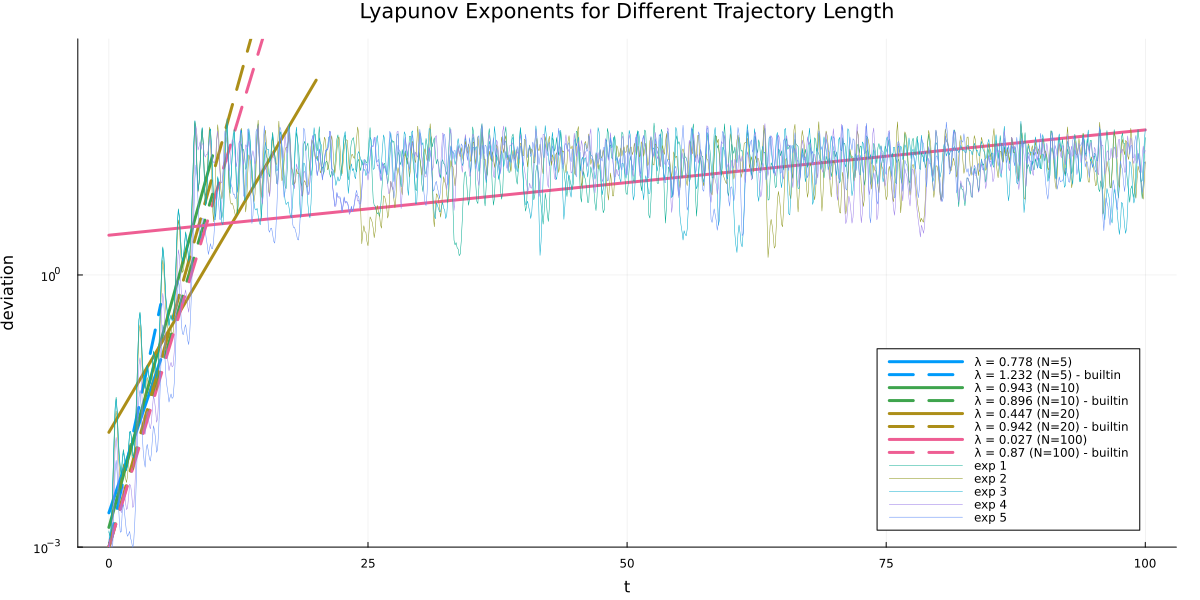

In [10]:
# define experiment parameters
n_exps = 5
T_trajs = [5, 10, 20, 100]
dt = 0.1

plt = Plots.plot(size=(1200, 600), margin=4mm, title="Lyapunov Exponents for Different Trajectory Length", xlabel="t", ylabel="deviation", ylim=[1e-3, 4e2], yaxis=:log)
for (i, T_traj) in enumerate(T_trajs)
    Random.seed!(3) # use same initial conditions for all experiments
    # run experiment
    t, diffs, coeffs, delta0_mean, lyapunov = estimate_lyapunov_exponent(Systems.lorenz(), end_point, T_traj; n_exp=n_exps, delta=[1e-4, 1e-3], dt=dt)
    ly_ds = DynamicalSystems.lyapunov(Systems.lorenz(), T_traj; u0=end_point, Δt=dt)

    # create the estimate deviation according to δ(t) = δ_0 * exp(λ*t)
    delta_estimate = delta0_mean * exp.(lyapunov .* t)
    delta_compare = 0.001 * exp.(ly_ds .* t)

    # plot difference of trajectories in log scale with averaged estimate of the Lyapunov exponent
    plt_ = Plots.plot!(t, delta_estimate, label="λ = $(round(lyapunov, digits=3)) (N=$T_traj)", legend=:bottomright, linewidth=3)
    line_color = plt_.series_list[end].plotattributes.explicit[:linecolor]
    Plots.plot!(t, delta_compare, label="λ = $(round(ly_ds, digits=3)) (N=$T_traj) - builtin", linecolor=line_color, legend=:bottomright, linewidth=3, linestyle=:dash)
    if i == length(T_trajs) Plots.plot!(t, diffs, label=reshape(["exp $i" for i in range(1, n_exps)], (1,n_exps)), linewidth=.5) end
end
plt

#### Interpretation
- the naive estimation of the Lyapunov exponent via linear regression is very sensitive to the length of the trajectory used for estimation
- the built-in `DynamicalSystems.lyapunov()` is quite robust w.r.t. the trajectory length, as can be seen by small variation of the estimated Lyapunov exponent